# PROJETO UNIFOR/UFC
## Modelo de Mineração de Texto para COVID-19
Erik Z. Solha

# 1 Carregando módulos

In [1]:
import pandas as pd
import numpy as np
import unidecode
import matplotlib.pyplot as plt
import datetime as dt
import math


# 2 Carregando base de atendimento das UPAs

In [2]:
cols = ["upa","paciente","data_atendimento","hor_chegada","data_classificao_risco",
        "hora_classificao_risco","data_nascimento","anos","meses","dsc_endereco","dsc_risco",
        "dsc_queixa","dsc_discriminador","sinais_sintomas_anamnese","cod_cid10","dsc_cid10","dsc_detalhe"]

In [3]:
path = 'datasets/base_atendimentos_upas_20221128-001.csv'

In [7]:
df_upas = pd.read_csv(path,
                      sep=';',
                      header=None,
                      names=cols,
                      encoding = 'latin1',
                      dtype=str)
df_upas.drop_duplicates(inplace = True, ignore_index = True)
df_upas = df_upas.drop(columns=['paciente', 'dsc_endereco'])

In [8]:
df_upas.head()

,upa,data_atendimento,hor_chegada,data_classificao_risco,hora_classificao_risco,data_nascimento,anos,meses,dsc_risco,dsc_queixa,dsc_discriminador,sinais_sintomas_anamnese,cod_cid10,dsc_cid10,dsc_detalhe
0,UPA PRAIA DO FUTURO,2022/11/28 00:00:00.000,07:59,2022/11/28 00:00:00.000,08:02,1948/04/13 00:00:00.000,"74,0","7,0",AMARELO,mal estar hj - encaminhada pelo samu,INICIO SUBITO,"PACIENTE TRAZIDA PELO SAMU DO HGF, PORÉM OS ME...",R53,"MAL ESTAR, FADIGA","R53 - MAL ESTAR, FADIGA|| ASTENIA SOE| CANSACO..."
1,UPA PRAIA DO FUTURO,2022/11/28 00:00:00.000,07:39,2022/11/28 00:00:00.000,07:43,1990/07/19 00:00:00.000,"32,0","4,0",VERDE,"odinofagia, febre e coriza hÀ 03 dias",DOR LEVE RECENTE,QP: DOR DE GARGANTA HDA: PACIENTE COM CEFALÉIA...,B34,"DOENCAS POR VIRUS, DE LOCALIZACAO NAO ESPECIFI...","B34 - DOENCAS POR VIRUS, DE LOCALIZACAO NAO ES..."
2,UPA PRAIA DO FUTURO,2022/11/28 00:00:00.000,07:20,2022/11/28 00:00:00.000,07:44,1957/01/18 00:00:00.000,"65,0","10,0",VERDE,lesão com inflamação e ardor em mid há 1 mês....,INFLAMAÇÃO LOCAL,"PACIENTE DIABÉTICA, HÁ 1 MÊS TEVE FERIMENTO EM...",S81,FERIMENTO DA PERNA,S81 - FERIMENTO DA PERNA|||EXCLUI:| AMPUTACAO ...
3,UPA PRAIA DO FUTURO,2022/11/28 00:00:00.000,07:20,2022/11/28 00:00:00.000,07:30,1957/01/18 00:00:00.000,"65,0","10,0",BRANCO,evasão,NÃO INFORMADO,"PACIENTE DIABÉTICA, HÁ 1 MÊS TEVE FERIMENTO EM...",S81,FERIMENTO DA PERNA,S81 - FERIMENTO DA PERNA|||EXCLUI:| AMPUTACAO ...
4,UPA PRAIA DO FUTURO,2022/11/28 00:00:00.000,06:40,2022/11/28 00:00:00.000,06:43,1976/03/12 00:00:00.000,"46,0","8,0",VERDE,"gripe, tosse há 3d",EVENTO RECENTE,"HÁ 4 DIAS VEM APERSENTANDO ODINOFAGIA, , SENSA...",J00,NASOFARINGITE AGUDA [RESFRIADO COMUM],J00 - NASOFARINGITE AGUDA [RESFRIADO COMUM]|| ...


In [9]:
df_upas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3327644 entries, 0 to 3327643
Data columns (total 15 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   upa                       object
 1   data_atendimento          object
 2   hor_chegada               object
 3   data_classificao_risco    object
 4   hora_classificao_risco    object
 5   data_nascimento           object
 6   anos                      object
 7   meses                     object
 8   dsc_risco                 object
 9   dsc_queixa                object
 10  dsc_discriminador         object
 11  sinais_sintomas_anamnese  object
 12  cod_cid10                 object
 13  dsc_cid10                 object
 14  dsc_detalhe               object
dtypes: object(15)
memory usage: 380.8+ MB


In [10]:
df_upas['upa'].value_counts()

upa
UPA JOSE WALTER        428901
UPA JANGURUSSU         422751
UPA CRISTO REDENTOR    394439
UPA CONJUNTO CEARA     373423
UPA ITAPERI            358424
UPA MESSEJANA          358191
UPA CANINDEZINHO       333271
UPA PRAIA DO FUTURO    330136
UPA AUTRAN NUNES       328108
Name: count, dtype: int64

# 3 Séries Temporais

## 3.1 Criação da Série de Suspeitos

In [32]:
def CriaSerieSuspeitos(df):
    df['data_atendimento'] = pd.to_datetime(df['data_atendimento'], format='%Y/%m/%d')
    existe_suspeita = np.zeros(len(df))

    sinonimos = ['falta de ar', 'dispneia', 'desconforto respiratorio']
    sintomas = ['febre', 'tosse']

    for indice, linha in df.iterrows():
        if isinstance(linha['dsc_queixa'], str):
            queixa = unidecode.unidecode(linha['dsc_queixa'].lower())
            for sinonimo in sinonimos:
                if sinonimo in queixa:
                    for sintoma in sintomas:
                        if sintoma in queixa:
                            existe_suspeita[indice] = 1
                            break
                            
    df['existe_suspeita'] = existe_suspeita.astype(int)
    suspeitos = df[df['existe_suspeita']==1].sort_values(by='data_atendimento')

    suspeitos = suspeitos[['data_atendimento', 'existe_suspeita']].groupby('data_atendimento').size()

    return suspeitos

In [33]:
suspeitos = CriaSerieSuspeitos(df_upas)

In [34]:
suspeitos

data_atendimento
2019-01-01     26
2019-01-02     36
2019-01-03     47
2019-01-04     38
2019-01-05     40
             ... 
2022-11-24    104
2022-11-25     83
2022-11-26     81
2022-11-27     79
2022-11-28     13
Length: 1428, dtype: int64

In [36]:
suspeitos.sum()

87536

## 3.2 Carregando dados de casos confirmados


In [12]:
path = 'datasets/casos-confirmados-integrasus-2022-07-13-07-30-38.csv'

In [14]:
df_confirmados = pd.read_csv(path,
                             sep=';',
                             dtype=str)
df_confirmados.head()

,ID REDCAP,ID ESUS,RESULTADO TESTE ESUS,CLASSIFICAÇÃO FINAL ESUS,ID SIVEP,NOME PACIENTE,DATA NASCIMENTO,SEXO PACIENTE,IBGE,MUNICIPIO PACIENTE,...,BAIRRO PACIENTE,CEP PACIENTE,DATA NOTIFICACAO,DATA INICIO SINTOMAS,LABORATORIO,TIPO TESTE,DATA DA COLETA,DATA RESULTADO EXAME,ID GAL,base
0,NaN,232179088019,Detectável,Confirmado Laboratorial,316203213837,PAULINO ALMEIDA DA SILVA,02/01/1953,MASCULINO,231090,PIQUET CARNEIRO,...,ALTO ALEGRE,63605000,26/04/2021,21/04/2021,LACEN,RT-PCR,27/04/2021,30/04/2021,0,sivep
1,NaN,NaN,NaN,NaN,315972311285,MANOEL PEREIRA DOS SANTOS\t,03/04/1924,MASCULINO,230440,FORTALEZA,...,HENRIQUE JORGE,60510415,11/08/2020,01/08/2020,LACEN,RT-PCR,11/08/2020,16/08/2020,100527159,sivep
2,NaN,232003579151,NaN,NaN,316346666581,VALFREDO RODRIGUES DA SILVA,15/03/1950,MASCULINO,230440,FORTALEZA,...,SALINAS,60810821,11/06/2020,05/06/2020,LACEN,RT-PCR,11/06/2020,14/06/2020,101119001349,sivep
3,NaN,NaN,NaN,NaN,NaN,FRANCISCO GERALDO NUNES,02/02/1963,MASCULINO,230030,ACOPIARA,...,NOVA ACOPIARA,NaN,NaN,27/03/2021,Outros,RT-PCR,27/03/2021,NaN,1011881.0,gal
4,NaN,232174251488,NaN,NaN,316179920735,ANA MARIA RODRIGUES FERREIRA,06/07/1966,FEMININO,230440,FORTALEZA,...,VICENTE PINZON,NaN,27/03/2021,27/03/2021,LACEN,RT-PCR,27/03/2021,28/03/2021,10160002636,sivep


In [15]:
df_confirmados['DATA NOTIFICACAO'] = pd.to_datetime(df_confirmados['DATA NOTIFICACAO'], format='%d/%m/%Y')

In [16]:
df_confirmados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1283560 entries, 0 to 1283559
Data columns (total 21 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   ID REDCAP                 0 non-null        object        
 1   ID ESUS                   1114097 non-null  object        
 2   RESULTADO TESTE ESUS      913948 non-null   object        
 3   CLASSIFICAÇÃO FINAL ESUS  657994 non-null   object        
 4   ID SIVEP                  51935 non-null    object        
 5   NOME PACIENTE             1283560 non-null  object        
 6   DATA NASCIMENTO           1281367 non-null  object        
 7   SEXO PACIENTE             1283553 non-null  object        
 8   IBGE                      1265593 non-null  object        
 9   MUNICIPIO PACIENTE        1265593 non-null  object        
 10  ENDEREÇO PACIENTE         1171138 non-null  object        
 11  BAIRRO PACIENTE           1111614 non-null  object

In [17]:
confirmados = df_confirmados.groupby('DATA NOTIFICACAO')['DATA NOTIFICACAO'].count()

In [18]:
confirmados

DATA NOTIFICACAO
2020-01-01      1
2020-01-02      2
2020-01-04      3
2020-01-05      2
2020-01-06      2
             ... 
2022-07-08    690
2022-07-09    199
2022-07-10    111
2022-07-11    706
2022-07-12    412
Name: DATA NOTIFICACAO, Length: 884, dtype: int64

## 3.3 Correlação entre as séries

In [30]:
def lista_de_datas(data_inicial, data_final):
    n = (data_final - data_inicial).days + 1

    datas = []
    for i in range(n):
        datas.append(data_inicial + dt.timedelta(i))
    return datas

In [31]:
suspeitos.index[-1].date()

datetime.date(2022, 11, 28)

In [32]:
vetor_data = lista_de_datas(dt.date(2020,1,1), suspeitos.index[-1].date())

In [33]:
len(vetor_data)

1063

In [34]:
dict_suspeitos = suspeitos.to_dict()
dict_confirmados = confirmados.to_dict()

In [35]:
dict_suspeitos_ajuste = {}
dict_confirmados_ajuste = {}
for key, value in dict_suspeitos.items():
    dict_suspeitos_ajuste[key.date()] = value

for key, value in dict_confirmados.items():
    dict_confirmados_ajuste[key.date()] = value

In [36]:
lista_suspeitos = []
lista_confirmados = []

for indice, data in enumerate(vetor_data):
    if data in dict_suspeitos_ajuste:
        lista_suspeitos.append(dict_suspeitos_ajuste[data])
    else:
        lista_suspeitos.append(np.nan)
  
    if data in dict_confirmados_ajuste:
        lista_confirmados.append(dict_confirmados_ajuste[data])
    else:
        lista_confirmados.append(np.nan)

In [37]:
d = {'suspeitos': lista_suspeitos, 'confirmados': lista_confirmados}

In [38]:
df_corr = pd.DataFrame(data = d, index = vetor_data)

In [39]:
df_corr.head()

,suspeitos,confirmados
2020-01-01,30,1.0
2020-01-02,47,2.0
2020-01-03,41,NaN
2020-01-04,46,3.0
2020-01-05,35,2.0


In [40]:
df_corr['suspeitos'] = df_corr['suspeitos'].replace(np.nan, 0.0)
df_corr['confirmados'] = df_corr['confirmados'].replace(np.nan, 0.0)

In [41]:
tamanho_janela = 7

janela_suspeitos = df_corr['suspeitos'].rolling(tamanho_janela, min_periods = 1)
df_corr['media_movel_suspeitos'] = janela_suspeitos.mean()

janela_confirmados = df_corr['confirmados'].rolling(tamanho_janela, min_periods = 1)
df_corr['media_movel_confirmados'] = janela_confirmados.mean()

In [42]:
df_corr.head()

,suspeitos,confirmados,media_movel_suspeitos,media_movel_confirmados
2020-01-01,30,1.0,30.000000,1.0
2020-01-02,47,2.0,38.500000,1.5
2020-01-03,41,0.0,39.333333,1.0
2020-01-04,46,3.0,41.000000,1.5
2020-01-05,35,2.0,39.800000,1.6


<AxesSubplot:>

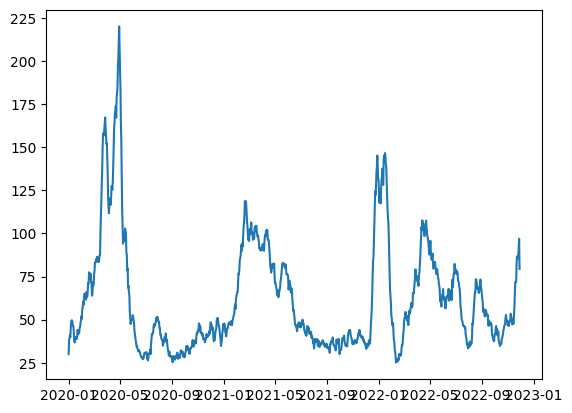

In [43]:
df_corr['media_movel_suspeitos'].plot()

In [44]:
df_corr.reset_index(drop = False, inplace = True)
df_corr.to_csv(r'datasets\tabela_correlacao_20221128.csv', sep = ';', index = False)

## 3.4 Separando as ondas

In [ ]:
df_onda1 = df_corr[df_corr.index < dt.date(2020, 11, 1)]
df_onda1

,suspeitos,confirmados,media_movel_suspeitos,media_movel_confirmados
2020-01-01,11.0,1.0,11.000000,1.000000
2020-01-02,11.0,2.0,11.000000,1.500000
2020-01-03,15.0,NaN,12.333333,1.500000
2020-01-04,14.0,3.0,12.750000,2.000000
2020-01-05,14.0,2.0,13.000000,2.000000
...,...,...,...,...
2020-10-27,10.0,696.0,11.857143,569.571429
2020-10-28,42.0,608.0,17.571429,558.857143
2020-10-29,31.0,727.0,20.428571,552.571429
2020-10-30,16.0,560.0,20.142857,528.142857


In [ ]:
df_onda2 = df_corr[(df_corr.index >= dt.date(2020, 11, 1)) & (df_corr.index < dt.date(2021, 11, 1))]
df_onda2

,suspeitos,confirmados,media_movel_suspeitos,media_movel_confirmados
2020-11-01,12.0,115.0,21.714286,528.857143
2020-11-02,17.0,197.0,20.857143,446.000000
2020-11-03,15.0,921.0,21.571429,478.142857
2020-11-04,18.0,705.0,18.142857,492.000000
2020-11-05,12.0,924.0,15.428571,520.142857
...,...,...,...,...
2021-10-27,15.0,235.0,15.000000,178.285714
2021-10-28,11.0,229.0,14.285714,175.142857
2021-10-29,18.0,183.0,15.285714,179.571429
2021-10-30,9.0,85.0,13.428571,182.857143


In [ ]:
df_onda3 = df_corr[(df_corr.index >= dt.date(2021, 11, 1)) & (df_corr.index < dt.date(2022, 5, 1))]
df_onda3

,suspeitos,confirmados,media_movel_suspeitos,media_movel_confirmados
2021-11-01,13.0,216.0,12.000000,176.714286
2021-11-02,15.0,75.0,12.857143,152.714286
2021-11-03,6.0,267.0,11.571429,157.285714
2021-11-04,16.0,287.0,12.285714,165.571429
2021-11-05,6.0,241.0,10.571429,173.857143
...,...,...,...,...
2022-04-26,16.0,96.0,20.714286,54.000000
2022-04-27,21.0,67.0,19.857143,49.571429
2022-04-28,34.0,52.0,21.142857,55.571429
2022-04-29,12.0,43.0,19.714286,55.428571


In [ ]:
df_onda4 = df_corr[df_corr.index >= dt.date(2022, 5, 1)]
df_onda4

,suspeitos,confirmados,media_movel_suspeitos,media_movel_confirmados
2022-05-01,13.0,10.0,18.714286,53.000000
2022-05-02,20.0,77.0,18.000000,51.714286
2022-05-03,16.0,42.0,18.000000,44.000000
2022-05-04,16.0,44.0,17.285714,40.714286
2022-05-05,19.0,48.0,15.142857,40.142857
...,...,...,...,...
2022-11-05,5.0,NaN,10.857143,NaN
2022-11-06,13.0,NaN,11.428571,NaN
2022-11-07,19.0,NaN,12.000000,NaN
2022-11-08,18.0,NaN,12.571429,NaN


## 3.5 Correlação
The arithmetic average of the sample, $ \overline{X_{j}} = \hat{\mu}_j $, is called the sample mean and provides an estimate of the first moment of inertia:

$$ \overline{X_{j}} = \frac{1}{N} \sum \limits _{t=1} ^{N} X^t_{j} $$

Because $ E(\overline{X_{j}}) = \mu_j , \overline{X_{j}} = \hat{\mu}_j $ is an unbiased estimator of $ \mu_j $.

Cross-correlation between $ \{X_i\} $ and $ \{X_j\} $ is defined by the ratio of covariance to root-mean variance,

$$ \rho_{i,j} = \frac {\gamma_{i.j}} {\sqrt{\sigma^2_i \sigma^2_j}} $$

Sample covariance is found from:

$$ \hat\gamma_{i.j} = \frac{1}{N} \sum \limits _{t=1}^{N} [(X^t_{i} - \overline{X_{i}})(X^{t}_{j} - \overline{X_{j}})] $$

Similarly, sample cross-correlation is defined by the ratio:

$$ \hat\rho_{i.j} = \frac {\sum \limits _{t=1}^{N} [(X^t_i - \overline{X_{i}})(X^{t}_{j} - \overline{X_{j}})]} {\sqrt {\sum \limits _{t=1}^{N} ({X_{i} - \overline{X_{i}}})^2 \sum \limits _{t=1}^{N} (X_{j} - \overline{X_{j}})^2}} $$

In [ ]:
# Pearson correlation function
def pearson_corr(x, y):
    N = len(x)
    num = 0
    sigma_x = 0
    sigma_y = 0
    for t in range(N):
        num = num + (x[t] - x.mean()) * (y[t] - y.mean())
        sigma_x = sigma_x + (x[t] - x.mean())**2
        sigma_y = sigma_y + (y[t] - y.mean())**2    
    sigma_x = math.sqrt(sigma_x)
    sigma_y = math.sqrt(sigma_y)
    den = sigma_x * sigma_y
    return num / den
 
# Pearson correlation as cross-correlation function
def pearson_as_ccf(x, y):
    rho_list = []
    for t in range(len(x)):
        rho = pearson_corr(x, np.roll(y, t))
        rho_list.append(rho)
    return rho_list

def get_max_corr(x, y):
    n = x.shape[0]
    rho = np.ndarray(n)
    for t in range(n):
        rho[t] = pearson_corr(x, np.roll(y, t))
    plt.plot(rho)
    idx = np.argmax(rho)
    val = rho[idx]
    return idx, val

In [ ]:
df_corr['corr'] = pearson_as_ccf(df_corr['media_movel_suspeitos'], df_corr['media_movel_confirmados'])

(72, 0.7822610077417027)

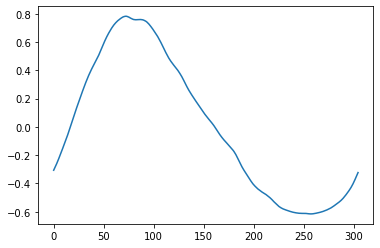

In [ ]:
get_max_corr(df_onda1['media_movel_confirmados'].to_numpy(), df_onda1['media_movel_suspeitos'].to_numpy())

(25, 0.9088638007232487)

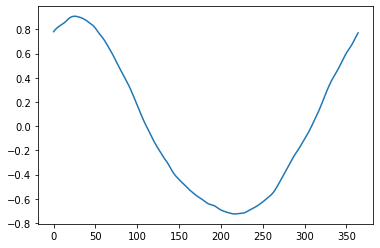

In [ ]:
get_max_corr(df_onda2['media_movel_confirmados'].to_numpy(), df_onda2['media_movel_suspeitos'].to_numpy())

(22, 0.8053255450669553)

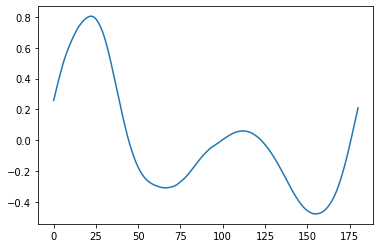

In [ ]:
get_max_corr(df_onda3['media_movel_confirmados'].to_numpy(), df_onda3['media_movel_suspeitos'].to_numpy())

(0, nan)

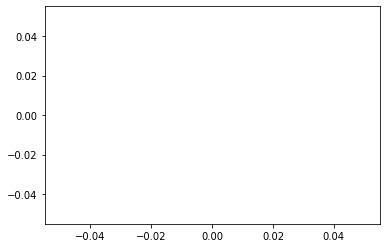

In [ ]:
get_max_corr(df_onda4['media_movel_confirmados'].to_numpy(), df_onda4['media_movel_suspeitos'].to_numpy())

In [ ]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1044 entries, 2020-01-01 to 2022-11-09
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   suspeitos                1043 non-null   float64
 1   confirmados              884 non-null    float64
 2   media_movel_suspeitos    1044 non-null   float64
 3   media_movel_confirmados  930 non-null    float64
 4   corr                     0 non-null      float64
dtypes: float64(5)
memory usage: 48.9+ KB


In [ ]:
df_corr

,suspeitos,confirmados,media_movel_suspeitos,media_movel_confirmados,corr
2020-01-01,11.0,1.0,11.000000,1.0,NaN
2020-01-02,11.0,2.0,11.000000,1.5,NaN
2020-01-03,15.0,NaN,12.333333,1.5,NaN
2020-01-04,14.0,3.0,12.750000,2.0,NaN
2020-01-05,14.0,2.0,13.000000,2.0,NaN
...,...,...,...,...,...
2022-11-05,5.0,NaN,10.857143,NaN,NaN
2022-11-06,13.0,NaN,11.428571,NaN,NaN
2022-11-07,19.0,NaN,12.000000,NaN,NaN
2022-11-08,18.0,NaN,12.571429,NaN,NaN


# 4 Plotando

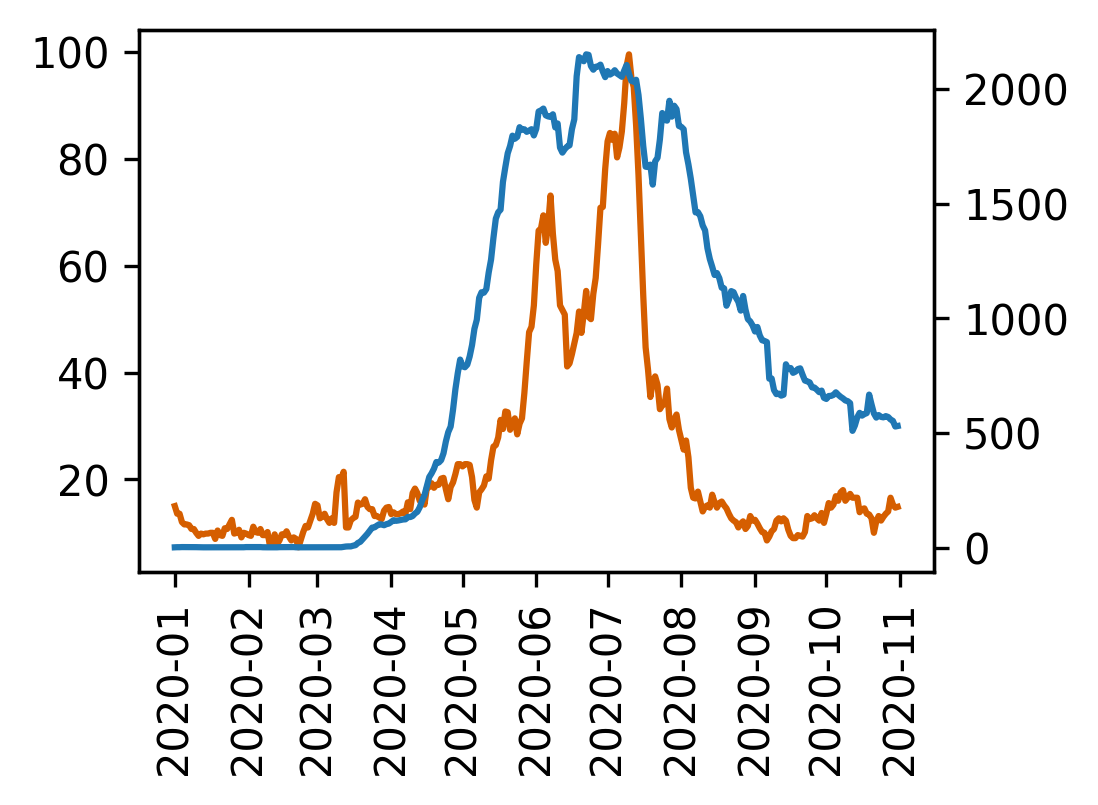

In [ ]:
figx = 3.42 #3.42, 4.5, 7
figy = (7/10) * figx


fig, ax = plt.subplots(dpi = 300, figsize=(figx,figy))

ax.plot(df_onda1.index, np.roll(df_onda1['media_movel_suspeitos'].to_numpy(), 72), color = '#D55E00')
y2 = ax.twinx()
y2.plot(df_onda1['media_movel_confirmados'])

ax.tick_params(axis = 'x', labelrotation=90)

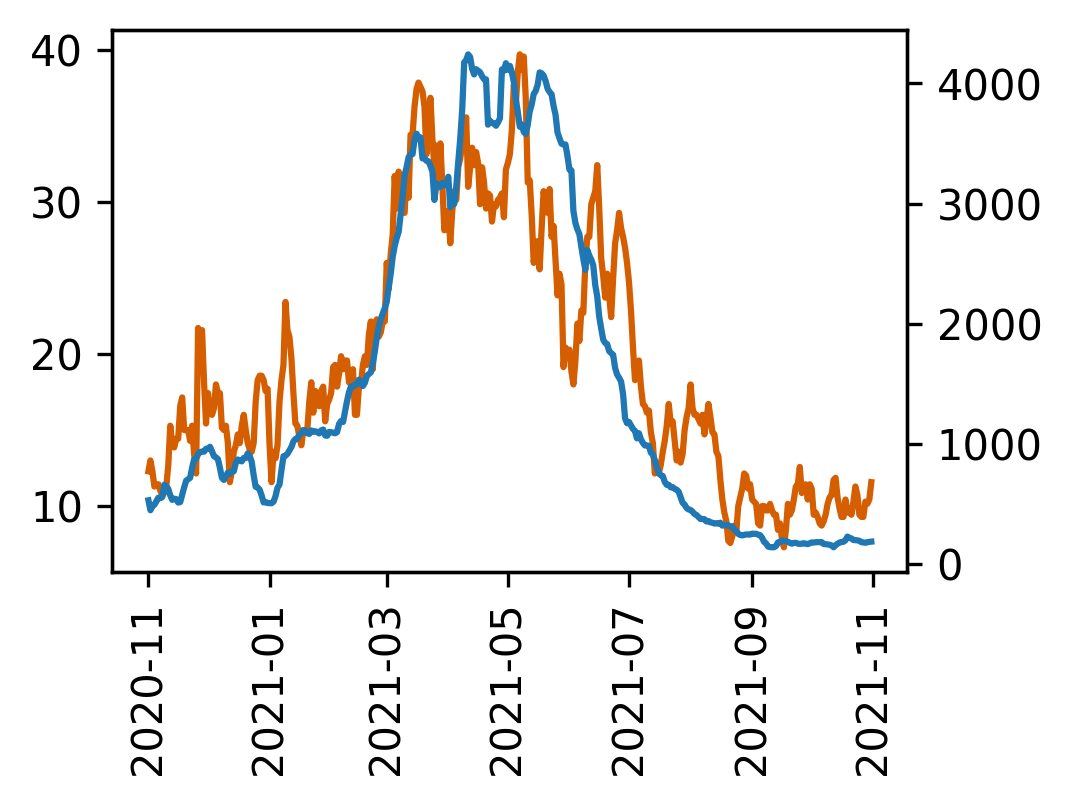

In [ ]:
figx = 3.42 #3.42, 4.5, 7
figy = (7/10) * figx


fig, ax = plt.subplots(dpi = 300, figsize=(figx,figy))

ax.plot(df_onda2.index, np.roll(df_onda2['media_movel_suspeitos'].to_numpy(), 25), color = '#D55E00')
y2 = ax.twinx()
y2.plot(df_onda2['media_movel_confirmados'])

ax.tick_params(axis = 'x', labelrotation=90)

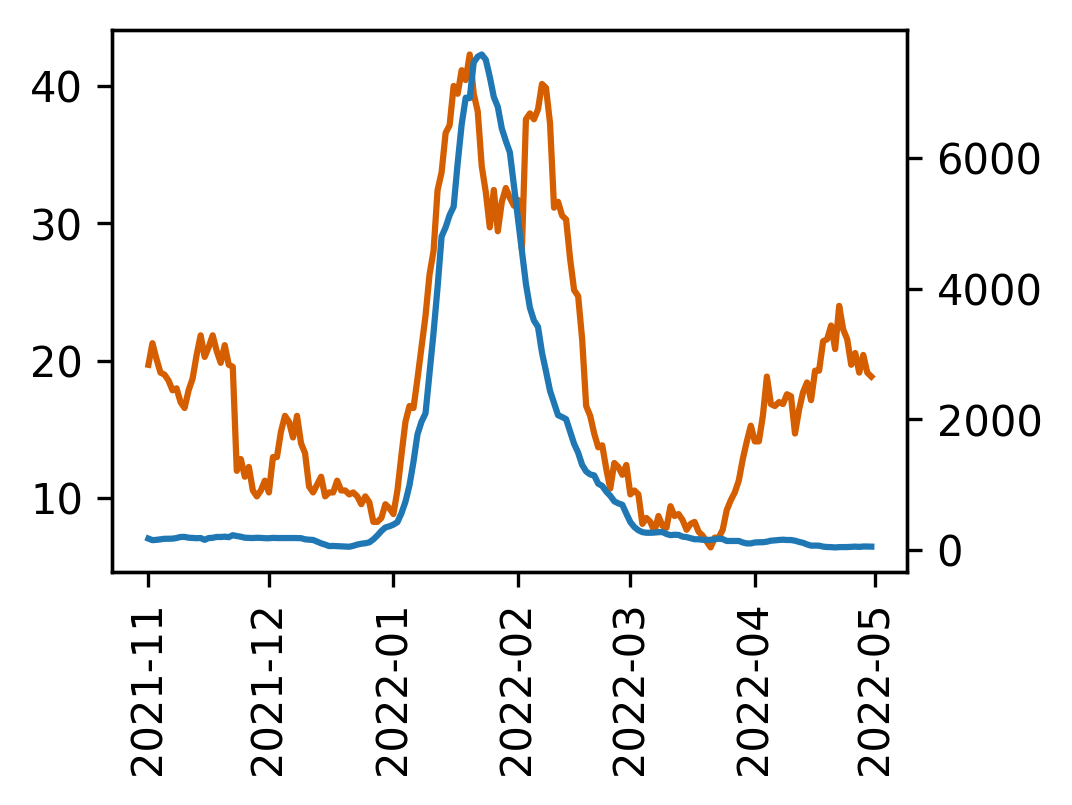

In [ ]:
figx = 3.42 #3.42, 4.5, 7
figy = (7/10) * figx


fig, ax = plt.subplots(dpi = 300, figsize=(figx,figy))

ax.plot(df_onda3.index, np.roll(df_onda3['media_movel_suspeitos'].to_numpy(), 22), color = '#D55E00')
y2 = ax.twinx()
y2.plot(df_onda3['media_movel_confirmados'])

ax.tick_params(axis = 'x', labelrotation=90)

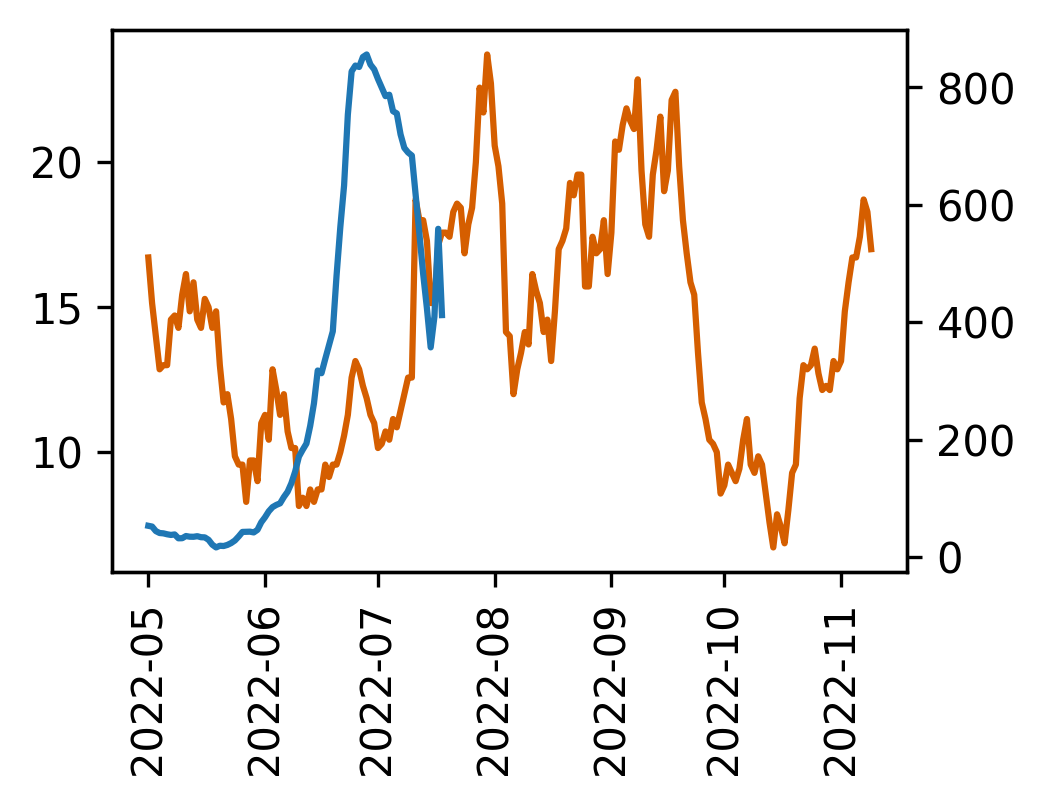

In [ ]:
figx = 3.42 #3.42, 4.5, 7
figy = (7/10) * figx


fig, ax = plt.subplots(dpi = 300, figsize=(figx,figy))

ax.plot(df_onda4.index, np.roll(df_onda4['media_movel_suspeitos'].to_numpy(), 71), color = '#D55E00')
y2 = ax.twinx()
y2.plot(df_onda4['media_movel_confirmados'])

ax.tick_params(axis = 'x', labelrotation=90)